# Hot Music Recommender

In [2]:
#libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import difflib #for typo control
import config # this are the spotify credentials for the song_recommender api
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
from time import sleep
from random import randint
import re #for getting rid of featured artist
import numpy as np
from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings



## Protype 1 - Reccommend song from scraped lists

### Retrieving music information from "The Hot 100 Chart - Billboard" 
weekly updated and will be scraped everytime a request is sent.

In [32]:
url = "https://www.billboard.com/charts/hot-100"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
    # song_title
song_title = []
for i in soup.find_all("span", {"class":"chart-element__information__song"}):
    song_title.append(i.text)
    
    #artist
song_artist = []
for i in soup.find_all("span", {"class":"chart-element__information__artist"}):
    song_artist.append(i.text)
    
#creating df from lists
Top100 = pd.DataFrame(list(zip(song_title, song_artist)),columns =['Title','Artist'],index=pd.RangeIndex(start=1, stop=101))
   
#Top100

### Loading music information from "DECADE-END CHARTS HOT 100 SONGS" and "Top "1000 Classic Rock Songs"

no update needed, therefore scraped once and saved as a csv

In [33]:
#Loading csv to use for the product and ensure that the index starts at 1
Top100Decade =pd.read_csv("data/Top100Decaden.csv")
Top100Decade.index=pd.RangeIndex(start=1, stop=101)
#Top100Decade

In [34]:
### Loading music information from "1,000 Classic Rock Songs"<a class="anchor" id="3"></a>
Top1000Rock =pd.read_csv("data/Top1000Rock.csv")
Top1000Rock.index=pd.RangeIndex(start=1, stop=1001)
#Top1000Rock

### Merging databases to have the option to search in all lists
not yet integrated in product

In [35]:
#drop peak from Top100Decade to have the same columns
Top100Decade_new = Top100Decade.drop(['Peak'], axis=1)

#merge all dataframes together
hot_songs = pd.concat([Top100, Top100Decade_new, Top1000Rock])

-----

------

In [36]:
#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))


In [37]:
# function to retrieve track ids from playlists (without limit of 50 with .ectend)
def get_playlist_ids(username,playlist_id):
    r = sp.user_playlist_tracks(username,playlist_id)
    t = r['items']
    ids = []
    while r['next']:
        r = sp.next(r)
        t.extend(r['items'])
    for s in t: ids.append(s["track"]["id"])
    return ids

In [38]:
#retrieving ids from spotifys 'biggest playlist'
#ids =get_playlist_ids('spotify','4rnleEAOdmFAbRcNCgZMpY')


In [39]:
#get all features for playlists songs
#df_playlist1 = pd.DataFrame(columns = sp.audio_features(res[0])[0].keys())

#for uri in ids:
    #my_dict_2 = sp.audio_features(uri)
    #df_playlist1 = df_playlist1.append(my_dict_2[0],ignore_index = True)

In [40]:
# save the playlist to a csv file
# df_playlist1.to_csv("biggest_playlist.csv", index = False)

------

In [41]:
# rafaats uri_track list
track_r =pd.read_csv("data/tracks_uris.csv")

tracks_r = track_r['uri'].tolist()


In [42]:
#get all features for songs
#df_2 = pd.DataFrame(columns = sp.audio_features(res[0])[0].keys())

#for uri in tracks_r:
#    dict_3 = sp.audio_features(uri)
#    df_2 = df_2.append(dict_3[0],ignore_index = True)
#    wait_time = randint(1,1)
#    #print("I will sleep for " + str(wait_time) + " second/s.")
#    sleep(wait_time)

In [43]:
# save the playlist to a csv file
# df_2.to_csv("data/biggest_track_list.csv", index = False)

--------

In [44]:
#df can be extended with other playlists
#for example:
#get categories from spotify
cats = [cat['id'] for cat in sp.categories()['categories']['items']]
#cats

toplists =sp.category_playlists('toplists')
toplists['playlists']['items'][0]['uri'] # gets the playlist id
#toplists

#getting all the playlist_ids from toplists
toplists_playlists =[]
for uri in toplists['playlists']['items'][:50]:
    uri = uri['uri']
    toplists_playlists.append(uri)
    
toplists_playlists=  [s.replace("spotify:playlist:", "") for s in toplists_playlists]
#toplists_playlists

#--> the code above could be used to get tracks from these playlists

### Loading all retrieved df audio features in one df

In [4]:
#loading dfs (the code above shouldn't be run each time but rather the saved file from it will be loaded)
df = pd.read_csv("data/biggest_playlist.csv")
df1 = pd.read_csv('data/biggest_track_list.csv')
#can be extended with other dfs


# combinging all dfs to one final df
spotify_audio_features = pd.concat([df, df1],ignore_index=True)
spotify_audio_features.shape

(15621, 18)

In [46]:
#drop duplicates
spotify_audio_features = spotify_audio_features.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
#spotify_audio_features.shape


------

### Clustering the df with the kmean method

In [47]:
#getting just the numerical features for scaling
X = spotify_audio_features.select_dtypes(include=np.number)
##add at the end the categorial features

In [48]:
#X.describe()

In [49]:
#K-Means is a distance based algorithm*: it needs to be scaled / normalized
scaler = StandardScaler()
scaler.fit(X) #z score 
X_scaled = scaler.transform(X) #gives an array
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns) #transform it to a df
display(X.head(2))
#print()
display(X_scaled_df.head(2))

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.566,0.664,4,-5.303,0,0.0464,0.634,0.0,0.116,0.437,128.945,241688,4
1,0.768,0.820,7,-4.630,0,0.0474,0.179,0.0,0.689,0.625,129.965,213293,4


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,-0.120361,-0.109797,-0.354500,0.388779,-1.25584,-0.525739,1.609740,-0.427602,-0.493842,-0.176487,0.234610,0.040565,0.173268
1,0.985614,0.599631,0.479688,0.537706,-1.25584,-0.515327,-0.063565,-0.427602,3.154594,0.587833,0.269851,-0.233615,0.173268


In [51]:
#X_scaled_df.describe()

### Chosing the best cluster number (K)

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

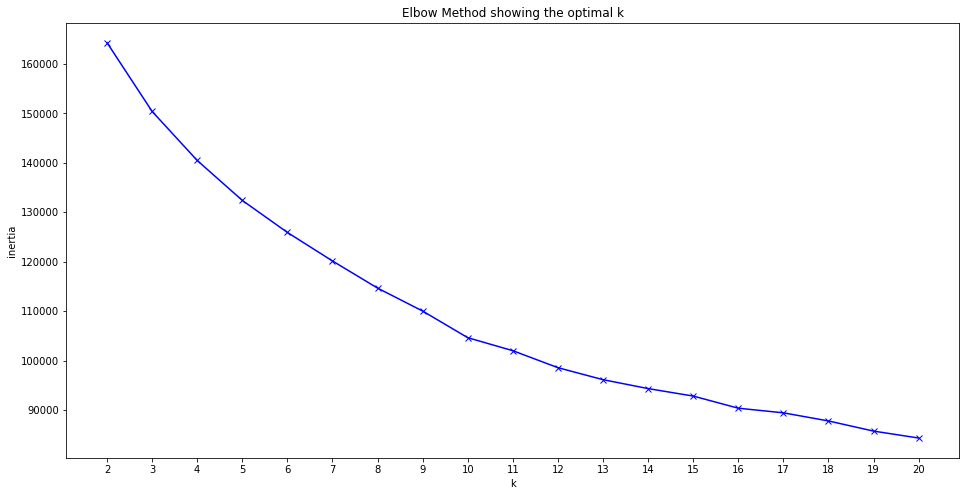

In [50]:
#Elbow-method

K = range(2, 21) # trying modul with different cluster amount
inertia = []

for k in K:
    #print("Training a K-Means model with {} neighbours! ".format(k))
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0)) 
plt.title('Elbow Method showing the optimal k')

There seems to be an elbow at **k=10**

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

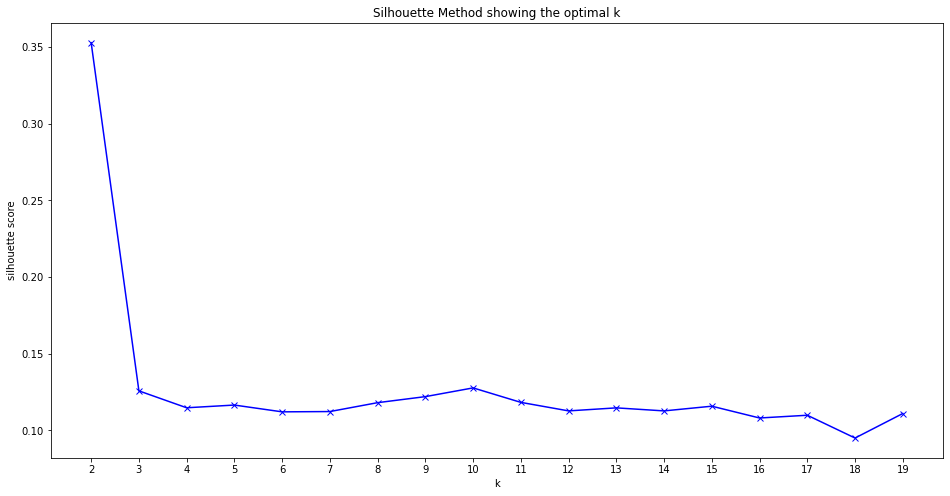

In [53]:
#Silouhette method
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    filename = "pickle/kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

**K=10** still seems to be the best option and also seems like a good number of music genres

In [54]:
#saving standardScaler
with open("pickle/scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)

In [53]:
#function to load pickles
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
    except FileNotFoundError: 
        print("File not found!") 

In [58]:
scaler2 = load("pickle/scaler.pickle")
scaler2

n_clusters = load("pickle/kmeans_10.pickle")
n_clusters

KMeans(n_clusters=10, random_state=1234)

### Clustering the spotify-audio-features with K-Means and K=10

In [59]:
kmeans = n_clusters #random_state = to get the same results like seed
kmeans.fit(X_scaled_df)

KMeans(n_clusters=10, random_state=1234)

In [60]:
#clustering the songs 
clusters = kmeans.predict(X_scaled_df) # tell how many observations are in each cluster
#clusters
pd.Series(clusters).value_counts().sort_index()

0    1392
1    3237
2     793
3    3766
4     729
5      51
6      92
7    1124
8    1515
9    2336
dtype: int64

In [61]:
##adding the categorial features again to the df
X_categorical = spotify_audio_features.select_dtypes(include=np.object)
X_final = pd.concat([X, X_categorical],axis =1)


In [63]:
#adding cluster to the data 
X_final["cluster"] = clusters
X_final.head(3)

#saving it to a csv
#X_final.to_csv("X_final.csv", index = False)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,type,id,uri,track_href,analysis_url,cluster
0,0.566,0.664,4,-5.303,0,0.0464,0.634,0.000000,0.116,0.437,128.945,241688,4,audio_features,7dS5EaCoMnN7DzlpT6aRn2,spotify:track:7dS5EaCoMnN7DzlpT6aRn2,https://api.spotify.com/v1/tracks/7dS5EaCoMnN7...,https://api.spotify.com/v1/audio-analysis/7dS5...,8
1,0.768,0.820,7,-4.630,0,0.0474,0.179,0.000000,0.689,0.625,129.965,213293,4,audio_features,2V4bv1fNWfTcyRJKmej6Sj,spotify:track:2V4bv1fNWfTcyRJKmej6Sj,https://api.spotify.com/v1/tracks/2V4bv1fNWfTc...,https://api.spotify.com/v1/audio-analysis/2V4b...,2
2,0.558,0.559,6,-9.222,1,0.0959,0.371,0.000007,0.109,0.620,78.558,180387,4,audio_features,7KA4W4McWYRpgf0fWsJZWB,spotify:track:7KA4W4McWYRpgf0fWsJZWB,https://api.spotify.com/v1/tracks/7KA4W4McWYRp...,https://api.spotify.com/v1/audio-analysis/7KA4...,3


------

# Final functions for product

In [64]:
#avoid typos  with difflib and by converting input into lower cases
def find_it(w):
    w = w.lower()
    return difflib.get_close_matches(w, Top100.Title.astype(str), n=3, cutoff=.7)

def find_it_decade(w):
    w = w.lower()
    return difflib.get_close_matches(w, Top100Decade.Title.astype(str), n=3, cutoff=.7)

def find_it_rock(w):
    w = w.lower()
    return difflib.get_close_matches(w, Top1000Rock.Title.astype(str), n=3, cutoff=.7)


In [65]:
def get_artists_from_id(id_):
    artists = sp.track(id_)['artists']
    artists_lst = [a['name'] for a in artists]
    return ", ".join(artists_lst)

In [66]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [76]:
def pick_song():
    warnings.filterwarnings('ignore') #do not display any warnings
    choose_song = input("\nEnter a " +color.BOLD+ " song " + color.END + " based on which you would like to receive a recommendation.\n\n")
    df = input("\nIn which charts do you want to search for a song? \nInput" +color.BOLD+ " 1 " + color.END + "for latest charts, " +color.BOLD+ " 2 " + color.END + " for decade-end charts and " +color.BOLD+ " 3 " + color.END + " for the Top 1,000 Classic Rock Songs:\n\n")
    #if a song is entered:       
    if df == "1":
        df = "Top100"
        choose_song1 = find_it(choose_song) #using difflib to detect typos
        choose_song1 = "".join(choose_song1) #convert list into string
        check = Top100.isin([choose_song1]).any().any()
    elif df == "2":
        df = "Top100 decade-end"
        choose_song1 = find_it_decade(choose_song) #using difflib to detect typos
        choose_song1 = "".join(choose_song1) #convert list into string
        check = Top100Decade.isin([choose_song1]).any().any()
    elif df == "3":
        df = "Top1000 Rock"
        choose_song1 = find_it_rock(choose_song) #using difflib to detect typos
        choose_song1 = "".join(choose_song1) #convert list into string
        check = Top1000Rock.isin([choose_song1]).any().any()
    else:
        print("\nYour input to select the charts was not correct.")
        return pick_song()
        
     

    if check :
        print("\nThe most similar song to your input in those charts is:", choose_song1)
        double_check = input("\nIs that the song you meant? Type y for yes and n for no:\n\n")
        if double_check == "y":
            print("\nThe song", choose_song1, "is in the", df, "charts. You might also like this song:\n\n")
            #now give a random reccommendations from the selectedcharts
            if df == "Top100":
                print(Top100.query('(Title != "choose_song1")').sample())
            if df == "Top100 decade-end":
                print(Top100Decade.query('(Title != "choose_song1")').sample())   
            if df == "Top1000 Rock":
                print(Top1000Rock.query('(Title != "choose_song1")').sample())   
        elif double_check == "n":
                print("\nNo worries, you can try it with another spelling or another song!")
                return pick_song() #or maybe to spotify step?
        else:
                print("\nYour input was not correct.")
                return pick_song()
              
                           
    else :
        print("\nThe song is unfortunately not in the", df,".\n")
        #global df
        sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                               client_secret= config.client_secret))
        # getting from input the audio feature of that song
        #q = input("Please enter your song again: ")
        song = sp.search(choose_song, limit=1) 
        my_dict = sp.audio_features(song["tracks"]["items"][0]["uri"])[0]
        my_dict_new = { key: [my_dict[key]] for key in list(my_dict.keys()) }
        my_dict_new=pd.DataFrame(my_dict_new)
    

        # check if it is in th df
        #tb done at a later point

        #retrieving just the numerical the input_features
        new = my_dict_new.select_dtypes(include=np.number)
        
        #scaling the audio_feature with the standardScaler
        #scaler.fit_transform(X[:, np.newaxis])
        #X_transformed = scaler.transform(X.T)
        scaler2 = StandardScaler()
        scaler2.fit(new) #z score 
        new_scaled = scaler2.transform(new) #gives an array
        new_scaled_df = pd.DataFrame(new_scaled, columns = new.columns) #transform it to a df
        

        #predict cluster for input
        predictions =kmeans.predict(new_scaled_df)
        cluster_p = predictions[0]

        #add cluster to input df
        new_scaled_df["cluster"] = cluster_p
        #return new_scaled_df
        

        song_to_recommend = X_final[X_final.cluster == new_scaled_df].sample(n=1)
        index = song_to_recommend.index[0]
        

        final_id = X_final.iloc[index]['id']
        print("But you might like this artist:", get_artists_from_id(final_id),"\n")
        print("Check out this song from the artist:","https://open.spotify.com/track/"+final_id)
      


        

In [77]:
pick_song()


Enter a  song  based on which you would like to receive a recommendation.

test

In which charts do you want to search for a song? 
Input 1 for latest charts,  2  for decade-end charts and  3  for the Top 1,000 Classic Rock Songs:

3

The song is unfortunately not in the Top1000 Rock .

But you might like this artist: Big Tymers, R. Kelly 

Check out this song from the artist: https://open.spotify.com/track/2C4RRPsDsjghWolIaodRh4
